## Demo: Denoising of multiple noise levels mouse brain cortex dataset
This notebook demonstrates training a EMDiffuse-n model for a 2D denoising task, Note that training a neural network for actual use should be done with **more training time** as used here.

## Download and install EMDiffuse

In [ ]:
# !git clone https://github.com/Luchixiang/EMDiffuse
# %cd EMDiffuse/

In [2]:
import sys
sys.path.append('Raft/core')
from RAFT.core.raftConfig import RaftConfig
from RAFT.core.register import registration
import os
import urllib
import zipfile
import glob
from tifffile import imread, imwrite
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/Users/luchixiang/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Download the Example Data

The example data consists of multiple noise level 2D images of mouse brain cortex.
The ground truth is high-SNR image with name 'Brain__4w_09.tif' and 'Brain__4w_04.tif' to 'Brain__4w_08.tif' are different noise level images

Text(0.5, 1.0, 'Ground Truth')

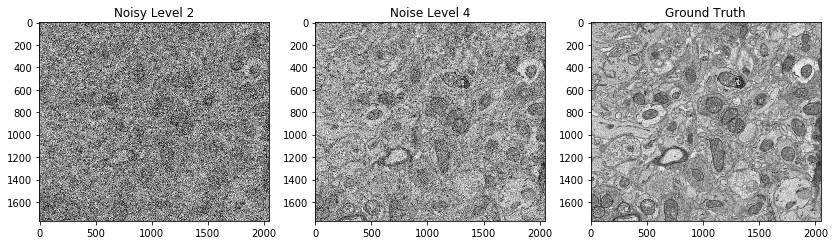

In [4]:
dataset_path = '/Users/luchixiang/Downloads/EMDiffuse_dataset_demo/brain_train'
subdir = glob.glob(os.path.join(dataset_path, '*'))
example_image_noise1 = imread(os.path.join(subdir[0], 'Brain__4w_05.tif'))
example_image_noise2 = imread(os.path.join(subdir[0], 'Brain__4w_07.tif'))
example_image_gt = imread(os.path.join(subdir[0], 'Brain__4w_09.tif'))
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plt.imshow(example_image_noise1, cmap='gray')
plt.title('Noisy Level 2')
plt.subplot(1,3,2)
plt.imshow(example_image_noise2, cmap='gray')
plt.title('Noise Level 4')
plt.subplot(1,3,3)
plt.imshow(example_image_gt, cmap='gray')
plt.title('Ground Truth')

In [2]:
# if not os.path.isdir('./dataset'):
#     os.mkdir('./dataset')

# # Here we only download the demo training datsaset, to download the whole dataset, replace the url with https://zenodo.org/records/10205819/files/EMDiffuse_dataset.zip?download=1.
# # Since the training Dataset is large, it may takes about 5 minutes to download the whole dataset and 1 minute to extract them.
# zipPath="dataset/EMDiffuse_data.zip"
# if not os.path.exists(zipPath):
#     #download and unzip data
#     data = urllib.request.urlretrieve('https://zenodo.org/api/records/10630002/files-archive', zipPath)
#     with zipfile.ZipFile(zipPath, 'r') as zip_ref:
#         zip_ref.extractall("dataset")

## Register and crop the patches
Optical flow registration and crop comes with a config-object. Key arguments:
 - path: A string indicating where the datasets store
 - patch_size: A int denoting size of image after crop. As a general rule, use a patch size that is a power of two along all axes, or which is at least divisible by 8. 
 - overlap: A int denoting overlap ratio of patches.
 - board: A int denoting the board to discard black region after registeration

In [3]:
# Set the optical flow registration and crop config
register_config = RaftConfig(path=dataset_path, patch_size=256, board=32, overlap=0.125)
# Start reistration and cropping
registration(register_config)

processing67, Brain__4w_07.tif


/Users/luchixiang/anaconda3/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/luchixiang/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:4228: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


The `registration` function will now register the noisy image with ground truth and generate lots of paired patches that will be used for training the EMDiffuse-n model later. The Cropped patch should be stored at the `denoise` folder under the dataset path


## Show Example Patch


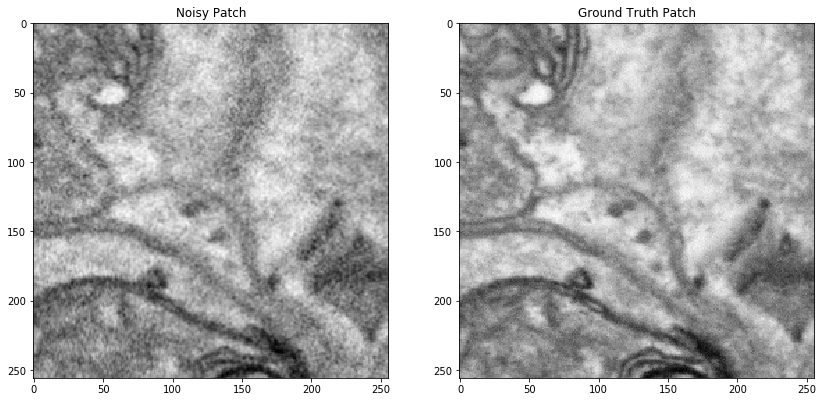

In [5]:
# Choose one sample to show

noise_images = glob.glob(os.path.join(dataset_path, 'denoise', 'train_wf', '*', '*', '*.tif'))
if len(noise_images) != 0:
    noisy_img =  imread(noise_images[0])
    gt_img = imread(noise_images[0].replace('train_wf', 'train_gt'))
    plt.figure(figsize=(14,7))
    plt.subplot(1,2,1)
    plt.imshow(noisy_img, cmap='gray')
    plt.title('Noisy Patch')
    plt.subplot(1,2,2)
    plt.imshow(gt_img, cmap='gray')
    plt.title('Ground Truth Patch')

In [1]:
import core.praser as Praser
import os
import warnings
import torch
import torch.multiprocessing as mp

from core.logger import VisualWriter, InfoLogger
import core.praser as Praser
import core.util as Util
from data import define_dataloader
from models import create_EMDiffuse
from emdiffuse_conifg import EMDiffuseConfig
from run import main_worker

## EMDiffuse Model
Before we construct the actual EMDiffuse model, we have to define its configuration via a Config object, which includes：
path: The dataset path of cropped patches.
config: Some basic parameters of the model, including the network architecutre, loss noise scheduler, dataset configuration, learning rate. Generally don't need to modify and see the config json files for more details
batch size: Training batch size on every gpu. 
mean: Diffusion model samples one plausible solution from the learned solution distribution. Mean denotes the number of outputs you want to generate and average. 
phase: run train or test.


In [8]:
config = EMDiffuseConfig(config='config/EMDiffuse-n.json', phase='train', 
                         path='/Users/luchixiang/Downloads/EMDiffuse_dataset_demo/brain_train/denoise/train_wf', batch_size=16, mean=2)
opt = Praser.parse(config) # Parse the config
opt['world_size'] = 1 
Util.set_seed(opt['seed'])
print(opt['distributed'])
model = create_EMDiffuse(opt)
print(f'len training data loader: {len(model.phase_loader)}, len validation dataloader: {len(model.val_loader)}')

False
{'data_root': '/Users/luchixiang/Downloads/EMDiffuse_dataset_demo/brain_train/denoise/train_wf', 'data_len': -1, 'norm': True, 'percent': False}
in dataset: /Users/luchixiang/Downloads/EMDiffuse_dataset_demo/brain_train/denoise/train_wf
train
network norm: True
len training data loader: 15, len validation dataloader: 1


## Training
Training the model will likely take some time. The model and logger information will be saved in a new folder named `./experiments/train_EMDiffuse-n_time` where time is the current time. Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on. 

In [7]:
model.train()

KeyboardInterrupt: 